In [2]:
import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sys import stdout
from openpyxl import Workbook


w1 = r'.\DATOS_EDITADOS\SNRG-0001_FINAL.las'
w2 = r'./Well_Logging/SNRG-0002_basic_logs.las'
w3 = r'./Well_Logging/SNRG-0003_basic_logs.las'
w4 = r'./Well_Logging/SNRG-0004_basic_logs.las'


In [3]:
las_1 = lasio.read(w1)
# las_1.to_csv(stdout)
df = las_1.df()
df.reset_index(inplace =True)
# df.to_excel("Registro_4.xlsx",sheet_name="Registro_4_Limpio",index=False)

In [4]:
#Cambio de nombres para diferentes tipos de cabezales
if "GRGC" in df:
    df = df.rename(columns={'GRGC':'GR'})
if ("RHOB" or "RHOZ") in df:
    df = df.rename(columns={'RHOB':'DEN'})
    df = df.rename(columns={'RHOZ':'DEN'})
if ("NPHI") in df:
    df = df.rename(columns={'NPHI':'NEU'})
if ("DDLL" or "AT90" or "RT" or "ILD") in df:
    df = df.rename(columns={'DDLL':'AT90'})
    df = df.rename(columns={'AT90':'AT90'})
    df = df.rename(columns={'RT':'AT90'})
    df = df.rename(columns={'IDL':'AT90'})
if ("PDPE" or "PEFZ") in df:
    df = df.rename(columns={'PDPE':'PEF'})
    df = df.rename(columns={'PEFZ':'PEF'})
df

,DEPTH,AT90,BIT,DCOR,DEN,DSLL,DT35,GR,NEU,NPRD,NPRL,NPRS,PEF,TOC
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


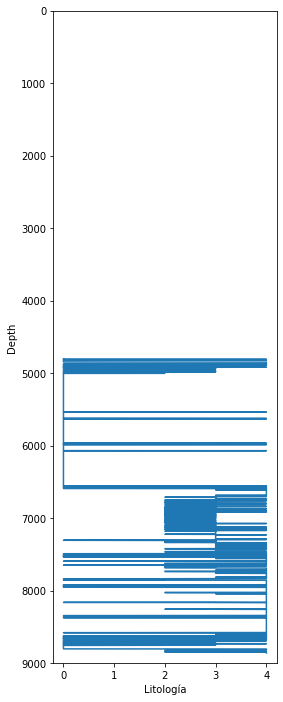

In [5]:
# Identifciación de los valores maximos y minimos del gamma ray
GR_max = df['GR'].max()
GR_min = df['GR'].min()

#Identificación de shale del resto de litologías
df.loc[df.GR>80,'Shale']= 0
df.loc[df.GR<80,'Shale']= 1

#Identificación de litologias mediante Neutron y Gamma Ray
df["Lit_ND"] = (df["DEN"] - 1.95) - (1 - (5/3)*(df["NEU"]+0.15))

# #Creación de la gráfica de litología
# fig , axs = plt.subplots(figsize=(4,12))
# plt.plot(df['Lit_ND'],df['DEPTH'])
# plt.xlabel('Litología')
# plt.ylabel('Depth')
# plt.ylim(max(df['DEPTH']),min(df['DEPTH']))
# # fig.savefig("DEPTH_vs_Lit_ND.png")

#Creacion de la litología con curvas
# Si es menor -0.03 Arenisca  2
df.loc[df.Lit_ND < -0.03,'Litologia']= 2
# Si esta en el rango de -0.03 a 0.03 limolita 3
df.loc[df.Lit_ND >= -0.03,'Litologia']= 3
#Si es mayor a 0.03 Dolomita 4
df.loc[df.Lit_ND > 0.03,'Litologia']= 4


df['Litologia'] = df['Litologia'] * df['Shale']

df
# # #Creación de la gráfica de litología
fig , axs = plt.subplots(figsize=(4,12))
plt.plot(df['Litologia'],df['DEPTH'])
plt.xlabel('Litología')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH']),min(df['DEPTH']))
# # fig.savefig("DEPTH_vs_Lit_ND.png")

df.to_excel('registro_prueba.xlsx',sheet_name='prueba',index=False)

In [6]:
#Asignacion de fila de matriz density
df.loc[df.Litologia == 0,'Matrix_DEN']= 2.65
df.loc[df.Litologia == 2,'Matrix_DEN']= 2.654
df.loc[df.Litologia == 3,'Matrix_DEN']= 2.711
df.loc[df.Litologia == 4,'Matrix_DEN']= 2.87


In [7]:
#Calculo de volumen de kerogeno
df['VolK'] = (1.19 * df['TOC'] * df['DEN'])/( 100 * 1.24)

#Correcion de densidad por TOC
df.loc[df.TOC != 0,'DEN_K'] = (df['DEN'] - (1.24 * df['VolK'] )) / ( 1 - df['VolK'])

#Porosidad del kerogeno
df['Poro_K'] = 0.2 * df['TOC'] * df['DEN']

In [8]:
#Porosidad density total
df.loc[df.DEN > 0,'Density'] = ((df['Matrix_DEN']-df['DEN'])/(df['Matrix_DEN']-1))
df.loc[df.DEN_K > 0,'Density'] = ((df['Matrix_DEN']-df['DEN_K'])/(df['Matrix_DEN']-1)) + df['Poro_K']

# Corrección de valores negativos
df.loc[df.Density > 0 ,'DEN_TOTAL'] = ""
df.loc[df.Density > 0 ,'DEN_TOTAL'] = df['Density']

#Porosidad Total Neutron mas density
df['Total_Poro'] = ( df['NEU'] + df['DEN_TOTAL'])/2

In [9]:
#Calculo de la temperatura de la formacion
df.loc[df.DEPTH <= 100,'Temperature'] = 75
df.loc[df.DEPTH > 100,'Temperature'] = 75 + (0.74 * (df['DEPTH'] - 100) / 100)

In [10]:
#Cálculo de la resistividad de la formación
df.loc[df.DEPTH > 100,'RES_CORR'] = 0.2 * ( 75 + 6.77) / ( df['Temperature'] + 6.77 )

In [11]:
#Calculo de Vclay
GR = df['GR']
IGR = (GR-GR_min)/(GR_max-GR_min)
df['Vclay']= 1.7 - ( 3.38 - ( IGR + 0.7) ** 2 ) ** 0.5
df.loc[df.Vclay > 0.7, 'Vclay'] = 0.7

In [12]:
#Calculo de m y a
df.loc[df.Vclay < 0.71, 'm'] = 1.08
df.loc[df.Vclay < 0.35, 'm'] = 1.33
df.loc[df.Vclay < 0.15, 'm'] = 1.54
df.loc[df.Vclay < 0.05, 'm'] = 2

#Calculo de a
df.loc[df.Vclay < 0.71, 'a'] = 2.45
df.loc[df.Vclay < 0.35, 'a'] = 1.65
df.loc[df.Vclay < 0.15, 'a'] = 1.45
df.loc[df.Vclay < 0.05, 'a'] = 1

In [13]:
#identificar valores relacionados con el Gamma Ray
GR = df[df.GR == GR_max ]
resis_GR = GR['AT90'].max()
poro_GR = GR['Total_Poro'].max()

# Calculo de porosidad efectiva
poro_efectiva = (df.DEN_TOTAL - poro_GR * df.Vclay ) * 100
df.loc[poro_efectiva > 0, 'Poro_efective'] = poro_efectiva

# Calculo de la Sw de agua de indonesia
df['Sw'] = (( ( (df.Vclay ** ( 2 - df.Vclay)/resis_GR) ** (1 / 2) ) + ( (df.Poro_efective ** df.m ) / df.RES_CORR ) ** ( 1 / 2 ) ) ** 2  * df.AT90 ) ** ( -1 / 2 )
df

,DEPTH,AT90,BIT,DCOR,DEN,DSLL,DT35,GR,NEU,NPRD,...,Density,DEN_TOTAL,Total_Poro,Temperature,RES_CORR,Vclay,m,a,Poro_efective,Sw
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.0000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.0000,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.0000,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.0000,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.0000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,140.8452,0.110788,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,140.8489,0.110785,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,140.8526,0.110782,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,140.8563,0.110780,NaN,NaN,NaN,NaN,NaN
